In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
TEST_DIR = "/content/drive/MyDrive/mitbih_split_small/test"
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ECG.keras"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)


Found 2070 images belonging to 5 classes.


In [ ]:
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 388s 6s/step - accuracy: 0.9309 - loss: 0.2296

Test Accuracy: 93.57%
Test Loss: 0.1878


In [ ]:

pred_probs = model.predict(test_data)
pred_classes = np.argmax(pred_probs, axis=1)

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step

Classification Report:
              precision    recall  f1-score   support

           F       0.93      0.82      0.87       120
           N       0.90      0.97      0.93       750
           Q       0.99      0.97      0.98       450
           S       0.94      0.83      0.88       300
           V       0.95      0.95      0.95       450

    accuracy                           0.94      2070
   macro avg       0.94      0.91      0.92      2070
weighted avg       0.94      0.94      0.94      2070



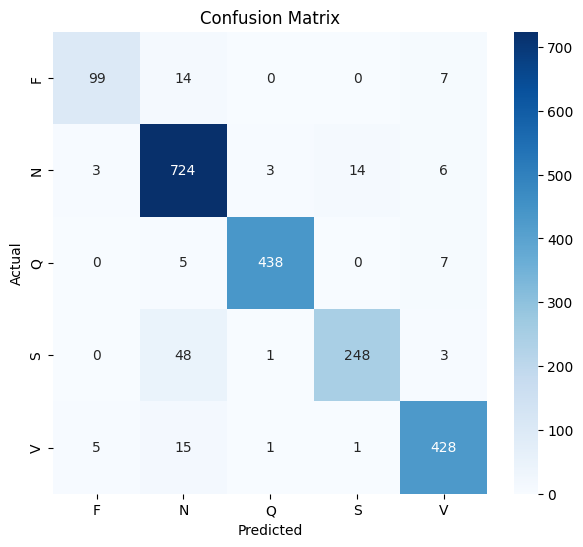

In [ ]:
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

65/65 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step


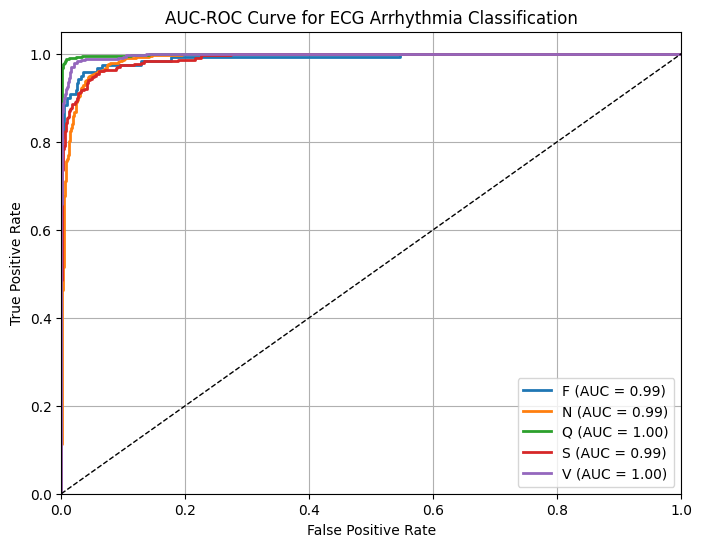

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())
n_classes = len(class_labels)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

y_score = model.predict(test_data)

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2,
             label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

# Plot settings
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curve for ECG Arrhythmia Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model_path = "/content/drive/MyDrive/Colab Notebooks/ECG.keras"
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import cv2
import matplotlib.pyplot as plt

CLASS_NAMES = ["F", "N", "Q", "S", "V"]

def predict_ecg(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (224, 224))
    img_norm = img_resized.astype("float32") / 255.0

    img_input = np.expand_dims(img_norm, axis=0)

    preds = model.predict(img_input)
    pred_class = np.argmax(preds)
    pred_label = CLASS_NAMES[pred_class]

    plt.imshow(img)
    plt.title(f"Predicted Class: {pred_label}")
    plt.axis("off")
    plt.show()

    print("----------- Prediction -----------")
    print(f"Class: {pred_label}")
    print("----------------------------------")

    return pred_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


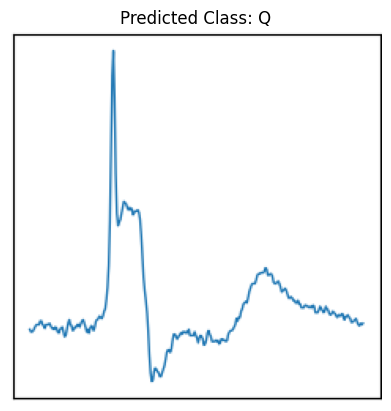

----------- Prediction -----------
Class: Q
----------------------------------


'Q'

In [ ]:
img_path = "/content/drive/MyDrive/mitbih_split_small/test/Q/102_122075_418.png"
predict_ecg(img_path)

✅ Model architecture built and weights loaded.
Using Grad-CAM Layer: last_conv


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_264']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


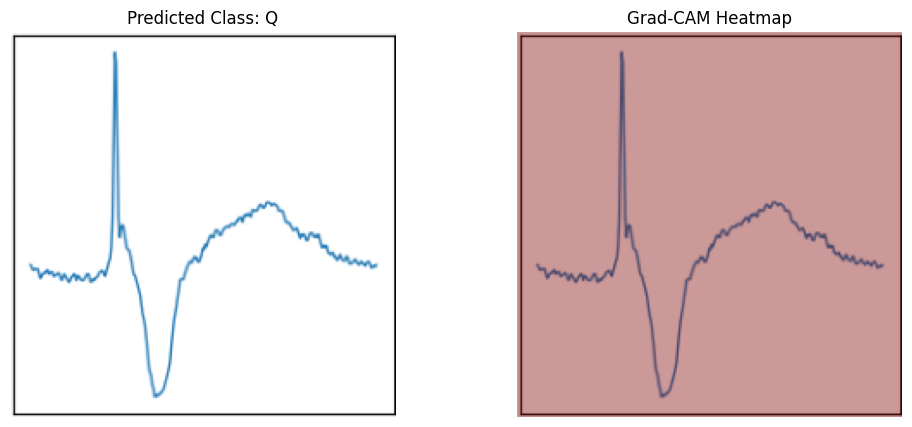

----------- Prediction -----------
Class: Q
Reason: Unknown/paced beat predicted: mean intensity=0.97 low/high beyond threshold, indicating noise or pacemaker artifact.
----------------------------------


('Q',
 'Unknown/paced beat predicted: mean intensity=0.97 low/high beyond threshold, indicating noise or pacemaker artifact.')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input

def build_model(num_classes=5):
    inputs = Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3,3), activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation="relu", name="last_conv")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

CLASS_NAMES = ["F", "N", "Q", "S", "V"]
def predict_with_gradcam_rule_extended(model, img_path, conv_layer_name="last_conv"):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or invalid path.")

    img = cv2.resize(img, (224,224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img_rgb.astype("float32")/255.0, axis=0)

    print("Using Grad-CAM Layer:", conv_layer_name)

    # Grad-CAM
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap + 1e-10)
    heatmap = (heatmap.numpy() if hasattr(heatmap, "numpy") else heatmap)
    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    pred_label = CLASS_NAMES[class_idx.numpy()]

    # ----------------------------
    # Rule-based reasoning based on image intensity
    # ----------------------------
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    max_val = np.max(gray)/255.0
    min_val = np.min(gray)/255.0
    mean_val = np.mean(gray)/255.0

    reasoning_dict = {
        "N": f"Normal beat predicted: max={max_val:.2f}, min={min_val:.2f}, mean={mean_val:.2f}. All values within normal range.",
        "S": f"Supraventricular beat predicted: max={max_val:.2f} (slightly higher peaks), min={min_val:.2f}. Small rapid deflections detected.",
        "V": f"Ventricular ectopic beat predicted: max={max_val:.2f} exceeds typical threshold (~0.7). Possibly wide QRS.",
        "F": f"Fusion beat predicted: variation in amplitude max={max_val:.2f}, min={min_val:.2f}. Mixed morphology detected.",
        "Q": f"Unknown/paced beat predicted: mean intensity={mean_val:.2f} low/high beyond threshold, indicating noise or pacemaker artifact."
    }
    reasoning = reasoning_dict.get(pred_label, "Unknown reason")

    # ----------------------------
    # Display results
    # ----------------------------
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title(f"Predicted Class: {pred_label}")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(superimposed)
    plt.axis("off")
    plt.show()

    print("----------- Prediction -----------")
    print(f"Class: {pred_label}")
    print(f"Reason: {reasoning}")
    print("----------------------------------")

    return pred_label, reasoning


checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/ECG.keras"

model = build_model(num_classes=5)
model.load_weights(checkpoint_path)
print("✅ Model architecture built and weights loaded.")

dummy_input = np.zeros((1,224,224,3), dtype=np.float32)
_ = model(dummy_input)

img_path = "/content/drive/MyDrive/mitbih_split_small/test/Q/104_383628_1395.png"
predict_with_gradcam_rule_extended(model, img_path)


✅ Model architecture built and weights loaded.
Using Grad-CAM Layer: last_conv


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


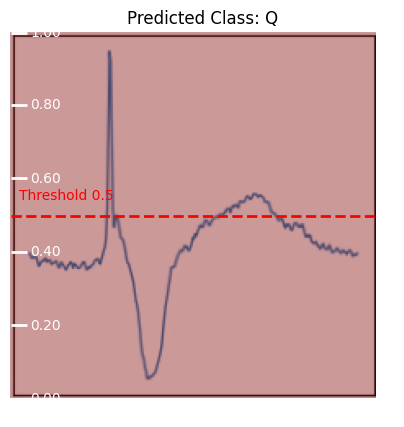

----------- Prediction -----------
Class: Q
Reason: Unknown/Paced: artifact or pacemaker spike
----------------------------------


('Q', 'Unknown/Paced: artifact or pacemaker spike')

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# ----------------------------
# 1️⃣ Build model
# ----------------------------
def build_model(num_classes=5):
    inputs = Input(shape=(224,224,3))
    x = layers.Conv2D(32,(3,3),activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,(3,3),activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,(3,3),activation="relu",name="last_conv")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes,activation="softmax")(x)
    model = models.Model(inputs=inputs,outputs=outputs)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    return model

CLASS_NAMES = ["F","N","Q","S","V"]

# ----------------------------
# 2️⃣ Grad-CAM with ruler + rule-based reasoning
# ----------------------------
def predict_with_gradcam_ruler(model,img_path,conv_layer_name="last_conv"):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or invalid path.")
    img = cv2.resize(img,(224,224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img_rgb.astype("float32")/255.0, axis=0)

    print("Using Grad-CAM Layer:",conv_layer_name)

    # Grad-CAM
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:,class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap + 1e-10)
    heatmap = (heatmap.numpy() if hasattr(heatmap,"numpy") else heatmap)
    heatmap = cv2.resize(heatmap,(224,224))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_rgb,0.6,heatmap,0.4,0)

    pred_label = CLASS_NAMES[class_idx.numpy()]

    # ----------------------------
    # Extract grayscale amplitude (as proxy for ECG voltage)
    gray = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY).astype("float32")/255.0
    h,w = gray.shape

    # ----------------------------
    # Define class thresholds (medical)
    thresholds = {
        "N": 0.6,   # proxy for normal QRS amplitude
        "V": 0.8,   # PVC: higher amplitude
        "S": 0.65,  # APC: slightly higher
        "F": 0.7,   # Fusion: intermediate
        "Q": 0.5    # Unknown/Paced
    }

    threshold_val = thresholds.get(pred_label,0.6)

    # ----------------------------
    # Plot with ruler
    fig,ax = plt.subplots(figsize=(12,5))
    ax.imshow(superimposed)
    ax.set_title(f"Predicted Class: {pred_label}")
    ax.axis("off")

    # Draw vertical ruler (left side)
    for t in np.linspace(0,1,6):  # 0.0,0.2,...1.0
        y = int((1-t)*h)
        ax.hlines(y, xmin=0, xmax=10, color="white", linewidth=2)
        ax.text(12,y,f"{t:.2f}",color="white", fontsize=10, va='center')

    # Draw predicted class threshold
    thresh_y = int((1-threshold_val)*h)
    ax.hlines(thresh_y, xmin=0, xmax=w, color="red", linewidth=2, linestyle="--")
    ax.text(5,thresh_y-10,f"Threshold {threshold_val}",color="red",fontsize=10)

    # Show Grad-CAM + ruler
    plt.show()

    # ----------------------------
    # Rule-based reasoning
    reasoning_dict = {
        "N": "Normal beat: QRS narrow, regular RR, P-wave present",
        "V": "Ventricular ectopic: wide QRS > 120ms, no P-wave, bizarre shape",
        "S": "Supraventricular ectopic: premature beat, normal QRS",
        "F": "Fusion: intermediate QRS morphology (mixed N+V)",
        "Q": "Unknown/Paced: artifact or pacemaker spike"
    }
    reasoning = reasoning_dict.get(pred_label,"Unknown reason")

    print("----------- Prediction -----------")
    print(f"Class: {pred_label}")
    print(f"Reason: {reasoning}")
    print("----------------------------------")

    return pred_label, reasoning

# ----------------------------
# 3️⃣ Load model & weights
# ----------------------------
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/ECG.keras"
model = build_model(num_classes=5)
model.load_weights(checkpoint_path)
print("✅ Model architecture built and weights loaded.")

dummy_input = np.zeros((1,224,224,3),dtype=np.float32)
_ = model(dummy_input)

# ----------------------------
# 4️⃣ Test image
# ----------------------------
img_path = "/content/drive/MyDrive/mitbih_split_small/test/Q/104_383628_1395.png"
predict_with_gradcam_ruler(model,img_path)


✅ Model architecture built and weights loaded.
Using Grad-CAM Layer: last_conv


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_66']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


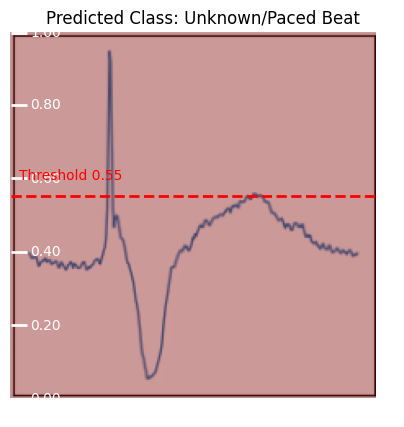

----------- Prediction & Advice -----------
Predicted Class: Unknown/Paced Beat
Explanation:
Unknown or Paced beat: Could be a pacemaker spike or artifact in ECG. This beat may not be generated naturally.
What you feel: Usually none if pacemaker is working properly; may notice minor irregularities if artifact.
Precautions: Ensure pacemaker is functioning correctly, attend scheduled check-ups.
Treatment: Adjustment of pacemaker settings if required, cardiologist follow-up.
-------------------------------------------


('Unknown/Paced Beat',
 'Unknown or Paced beat: Could be a pacemaker spike or artifact in ECG. This beat may not be generated naturally.\nWhat you feel: Usually none if pacemaker is working properly; may notice minor irregularities if artifact.\nPrecautions: Ensure pacemaker is functioning correctly, attend scheduled check-ups.\nTreatment: Adjustment of pacemaker settings if required, cardiologist follow-up.')

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# ----------------------------
# 1️⃣ Build model
# ----------------------------
def build_model(num_classes=5):
    inputs = Input(shape=(224,224,3))
    x = layers.Conv2D(32,(3,3),activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,(3,3),activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,(3,3),activation="relu",name="last_conv")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256,activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes,activation="softmax")(x)
    model = models.Model(inputs=inputs,outputs=outputs)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
    return model

# ----------------------------
# 2️⃣ Full descriptive class names
# ----------------------------
CLASS_NAMES = {
    "F": "Fusion Beat",
    "N": "Normal Beat",
    "Q": "Unknown/Paced Beat",
    "S": "Supraventricular Beat",
    "V": "Ventricular Ectopic Beat"
}

# ----------------------------
# 3️⃣ Grad-CAM with ruler + explanations + precautions + treatments
# ----------------------------
def predict_with_gradcam_ruler(model,img_path,conv_layer_name="last_conv"):
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found or invalid path.")
    img = cv2.resize(img,(224,224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img_rgb.astype("float32")/255.0, axis=0)

    print("Using Grad-CAM Layer:",conv_layer_name)

    # Grad-CAM
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:,class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap + 1e-10)
    heatmap = (heatmap.numpy() if hasattr(heatmap,"numpy") else heatmap)
    heatmap = cv2.resize(heatmap,(224,224))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_rgb,0.6,heatmap,0.4,0)

    pred_code = list(CLASS_NAMES.keys())[class_idx.numpy()]
    pred_label = CLASS_NAMES[pred_code]

    # ----------------------------
    # Extract grayscale amplitude (as proxy for ECG voltage)
    gray = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2GRAY).astype("float32")/255.0
    h,w = gray.shape

    # ----------------------------
    # Define thresholds for each full class (medical reference)
    thresholds = {
        "Normal Beat": 0.6,
        "Ventricular Ectopic Beat": 0.8,
        "Supraventricular Beat": 0.65,
        "Fusion Beat": 0.7,
        "Unknown/Paced Beat": 0.5
    }

    threshold_val = thresholds.get(pred_label,0.6)
    delta = 0.05
    upper_thresh = min(threshold_val + delta,1.0)
    lower_thresh = max(threshold_val - delta,0.0)

    # ----------------------------
    # Plot Grad-CAM with ruler and thresholds
    fig, ax = plt.subplots(figsize=(12,5))
    ax.imshow(superimposed)
    ax.set_title(f"Predicted Class: {pred_label}")
    ax.axis("off")

    # Vertical ruler on left
    for t in np.linspace(0,1,6):
        y = int((1-t)*h)
        ax.hlines(y, xmin=0, xmax=10, color="white", linewidth=2)
        ax.text(12, y, f"{t:.2f}", color="white", fontsize=10, va='center')

    # Draw only upper threshold
    upper_y = int((1-upper_thresh)*h)
    ax.hlines(upper_y, xmin=0, xmax=w, color="red", linewidth=2, linestyle="--")
    ax.text(5, upper_y-10, f"Threshold {upper_thresh:.2f}", color="red", fontsize=10)

    plt.show()


    # ----------------------------
    # Rule-based explanation, precautions, treatment stages
    explanations = {
        "Normal Beat": (
            "A normal heartbeat: Your heart rhythm is regular, QRS complex is normal, "
            "and P-wave is present. This means blood is being pumped effectively.\n"
            "What you feel: Usually nothing, normal heartbeat.\n"
            "Precautions: Maintain a healthy lifestyle, balanced diet, exercise, "
            "avoid excessive caffeine or alcohol, and attend regular check-ups.\n"
            "Treatment: None required for healthy individuals."
        ),
        "Ventricular Ectopic Beat": (
            "Ventricular ectopic beat: This is an early heartbeat originating from the ventricles. "
            "QRS is wide and abnormal, no P-wave detected. Blood flow may be slightly less efficient.\n"
            "What you feel: Palpitations, skipped beats, or a fluttering sensation in the chest.\n"
            "Precautions: Avoid stimulants (caffeine, alcohol, nicotine), manage stress, monitor heart rhythm.\n"
            "Treatment: Usually benign if infrequent; if frequent or symptomatic, your doctor may prescribe antiarrhythmic medication and recommend cardiologist follow-up."
        ),
        "Supraventricular Beat": (
            "Supraventricular beat: Early heartbeat originating from the atria. QRS is normal, but beat occurs prematurely.\n"
            "What you feel: Brief palpitations, sensation of skipped or rapid beats.\n"
            "Precautions: Reduce stress, avoid caffeine or energy drinks, maintain electrolyte balance.\n"
            "Treatment: Often benign; if frequent, doctor may prescribe beta-blockers or recommend monitoring."
        ),
        "Fusion Beat": (
            "Fusion beat: This occurs when a normal heartbeat and an ectopic ventricular beat combine, creating a hybrid QRS morphology.\n"
            "What you feel: May notice palpitations, irregular pulse, or skipped beats.\n"
            "Precautions: Regular heart monitoring, avoid stimulants and triggers like stress or lack of sleep.\n"
            "Treatment: Depends on underlying arrhythmia; your cardiologist may monitor or adjust medication."
        ),
        "Unknown/Paced Beat": (
            "Unknown or Paced beat: Could be a pacemaker spike or artifact in ECG. This beat may not be generated naturally.\n"
            "What you feel: Usually none if pacemaker is working properly; may notice minor irregularities if artifact.\n"
            "Precautions: Ensure pacemaker is functioning correctly, attend scheduled check-ups.\n"
            "Treatment: Adjustment of pacemaker settings if required, cardiologist follow-up."
        )
    }


    explanation = explanations.get(pred_label, "Unknown reason")

    print("----------- Prediction & Advice -----------")
    print(f"Predicted Class: {pred_label}")
    print(f"Explanation:\n{explanation}")
    print("-------------------------------------------")

    return pred_label, explanation

# ----------------------------
# 4️⃣ Load model & weights
# ----------------------------
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/ECG.keras"
model = build_model(num_classes=5)
model.load_weights(checkpoint_path)
print("✅ Model architecture built and weights loaded.")

dummy_input = np.zeros((1,224,224,3),dtype=np.float32)
_ = model(dummy_input)

# ----------------------------
# 5️⃣ Test image
# ----------------------------
img_path = "/content/drive/MyDrive/mitbih_split_small/test/Q/104_383628_1395.png"
predict_with_gradcam_ruler(model,img_path)
